### Autoencoders

Definición: https://www.ibm.com/es-es/topics/autoencoder 

Tipos:[ \[link\]](https://deeplearningofpython.blogspot.com/2023/05/Typesofautoencoders-implementation-keras.html?source=post_page-----383cfecc4d0e--------------------------------)

Como funcionan: https://www.geeksforgeeks.org/how-autoencoders-works/ 

Compresión de imágenes y regeneración de imágenes

- latent space: https://www.geeksforgeeks.org/what-is-latent-space-in-deep-learning/ 

- Reconstrucción imágenes a partir del espacio latente https://medium.com/@jaiganesan/autoencoder-is-simple-9055a7b5b935 

- Calidad de reconstrucción y pérdida de información: https://medium.com/@bhipanshudhupar/loss-functions-in-simple-autoencoders-mse-vs-l1-loss-4e838ae425b9 

- https://www.digitalocean.com/community/tutorials/convolutional-autoencoder 

Necessary libraries and modules for the tasks:

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader, Subset
from torchvision.datasets import CIFAR10
from torchvision.models import vgg19_bn
from torch.optim import Adam
from torchmetrics.functional.regression import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
import wandb
import numpy as np
import pylab as pl
import random
from IPython import display
from tqdm import tqdm


c:\Users\Aina Tur\miniconda3\envs\feina\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def wandb_initialization():
    wandb.init(
        # set the wandb project where this run will be logged
        project="autoencoder",

        # track hyperparameters and run metadata
        config={
        "architecture": "VGG19",
        "dataset": "CIFAR-10",
        "epochs": 100,
        }
    )

In [4]:
TRAINING_SIZE=15
TEST_SIZE=10

### Load Cifar10

In [5]:
training_set = CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]))
test_set = CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),  transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))]))

In [6]:
print(len(training_set))
print(len(test_set))

50000
10000


In [233]:
print(training_set[0][0].shape)

torch.Size([3, 32, 32])


In [9]:
train_dl = DataLoader(Subset(training_set, range(25000)), batch_size=TRAINING_SIZE,shuffle=True, num_workers=2)
test_dl = DataLoader(Subset(test_set, range(5000)), batch_size=TEST_SIZE,shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


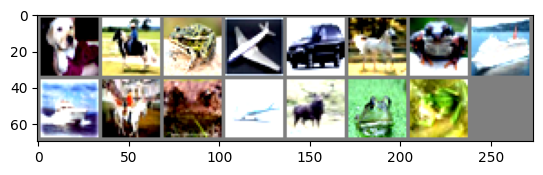

In [8]:
images, labels = next(iter(train_dl))
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0) / 2 + 0.5); 

### Model Architecture

#### Encoder

In [10]:
encoder = vgg19_bn(weights=None, progress=True)
encoder = encoder.features[:39]
print(encoder)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

#### Model

In [26]:
class AutoEncoder(torch.nn.Module):
	def __init__(self, encoder):
		super().__init__()
	
		self.encoder = encoder
	
		self.decoder = nn.Sequential(

		nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
      	nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1,1)),
      	nn.ReLU(inplace=True),


		nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1,1)),
      	nn.ReLU(inplace=True),

      
      
	    nn.ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
	    nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1,1)),
      	nn.ReLU(inplace=True),
		  
	    nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
      	nn.ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


# Training and evaluation

In [12]:
use_cuda = True
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(33)

In [27]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
loss = nn.MSELoss()

In [15]:
def traintestpipeline(epochs: int, optim: Adam, criterion: nn.MSELoss, min_loss: int, name: str):
    wandb_initialization()
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))
    pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
    for epoch in pbar:
        
        train_loss = 0 
        val_loss = 0  
        
        model.train()                                                  
        for (input_img, target) in tqdm(train_dl):
            input_img = input_img.to(device).float()
            # forward pass
            output = model(input_img)

            loss = criterion(output,input_img)
            t_acc = mean_squared_error(output, input_img)
            loss.backward()                                            
            optim.step()                                               
            optim.zero_grad()     
            
            train_loss += loss.item()   
                                                        
        model.eval()   
        with torch.no_grad():                                          
             for (input_img, target) in tqdm(test_dl):
                input_img = input_img.to(device).float()
                # forward pass
                output = model(input_img)
   
                loss = criterion(output, input_img)   
                v_acc = mean_squared_error(output, input_img)
                val_loss += loss.item()  
        
        # RESULTATS
        train_loss /= len(train_dl)
        t_loss[epoch-1] = train_loss
        
        val_loss /= len(test_dl)   
        v_loss[epoch-1] = val_loss
        if(v_loss[epoch-1]<min_loss):
            min_loss=v_loss[epoch-1]
            torch.save(model.state_dict(), name)  
        
        wandb.log({"acc": t_acc, "Trainingloss": train_loss})
        wandb.log({"acc": v_acc, "Validationloss": val_loss})
        # VISUALITZACIO DINAMICA
        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")
    wandb.finish()

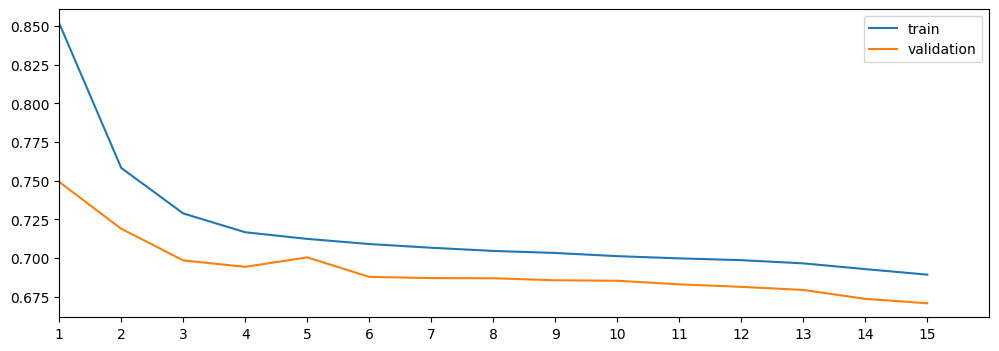

Epoch:15 Training Loss:0.6892089845359004 Validation Loss:0.6706872546076774: 100%|██████████| 15/15 [06:08<00:00, 24.53s/it]


Trainingloss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁
Validationloss,█▅▃▃▄▃▂▂▂▂▂▂▂▁▁
acc,▄▇▂▇▂▇▅▆▂▇▄▆▅▆▇▆▁▆▃▆▇▆▂▆▅▆▄▆█▆
Trainingloss,0.68921
Validationloss,0.67069
acc,0.73238


In [28]:
traintestpipeline(15,optimizer, loss, 10000, "AE.pt")

In [30]:
def showImages(test_dl, model):
    with torch.no_grad():
        model.eval()
        for data, _ in test_dl:  # Get one batch from the test DataLoader
                data = data.to(device).float()
                output = model(data)
                fig, ax = plt.subplots(1, 2, figsize=(8,4))
                ax[0].imshow(data[0].cpu().permute(1, 2, 0).numpy(), cmap='gray')
                ax[1].imshow(output[0].cpu().permute(1, 2, 0).numpy(), cmap='gray')
                ax[0].set_title("Origina Image")
                ax[1].set_title("Reconstructed Image")
                plt.show()
                break 

In [33]:
def assignPretrainedModel(device,name:str):
    mmodel =  model.to(device)
    mmodel.load_state_dict(torch.load(name))
    mmodel.eval()
    return mmodel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.5877128].


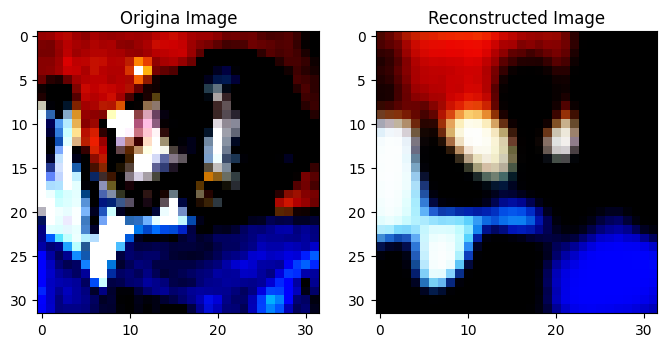

In [34]:
assignPretrainedModel(device, "AE.pt")
showImages(test_dl, model)

In [35]:
def calculate_metrics(model, test_dl, device):
    model.eval()
    total_mse = 0 
    total_mae = 0 

    total = len(test_dl)
    

    with torch.no_grad():
        for input_img, _ in test_dl:
            input_img = input_img.to(device).float()

            output = model(input_img)
            mse = mean_squared_error(output, input_img)
            total_mse += mse
            mae = mean_absolute_error(output, input_img) 
            total_mae += mae
    total_mse /=total
    total_mae /=total

    print("MSE:", total_mse)
    print("MAE:", total_mae)

In [36]:
calculate_metrics(model, test_dl, device)

MSE: tensor(0.6707, device='cuda:1')
MAE: tensor(0.6445, device='cuda:1')


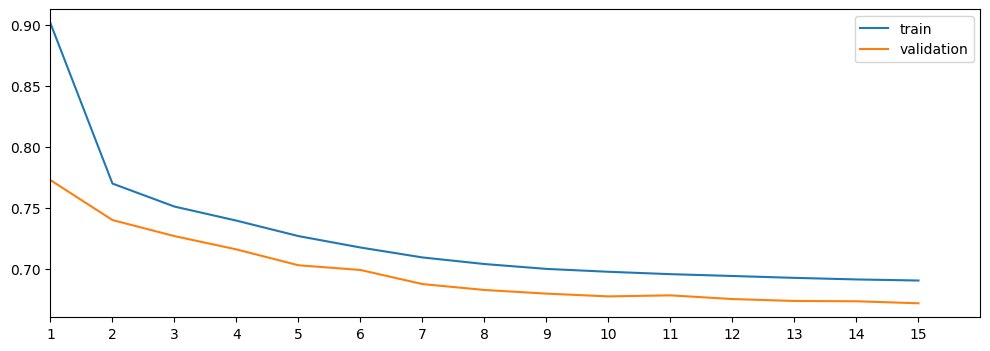

Epoch:15 Training Loss:0.6905120932991518 Validation Loss:0.6718439975976944: 100%|██████████| 15/15 [06:09<00:00, 24.65s/it]


Trainingloss,█▄▃▃▂▂▂▁▁▁▁▁▁▁▁
Validationloss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁
acc,▃▄▂▃▇▃▃▃▂▃▁▃▂▃▁▃▁▃▄▃▅▃▄▃▃▃▁▃█▃
Trainingloss,0.69051
Validationloss,0.67184
acc,0.73487


In [37]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-5)
loss = nn.MSELoss()
traintestpipeline(15,optimizer, loss, 10000, "AE2.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.5877128].


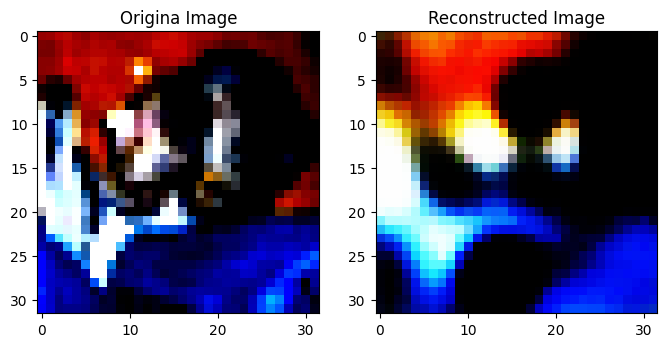

MSE: tensor(0.6718, device='cuda:1')
MAE: tensor(0.6464, device='cuda:1')


In [38]:
assignPretrainedModel(device, "AE2.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

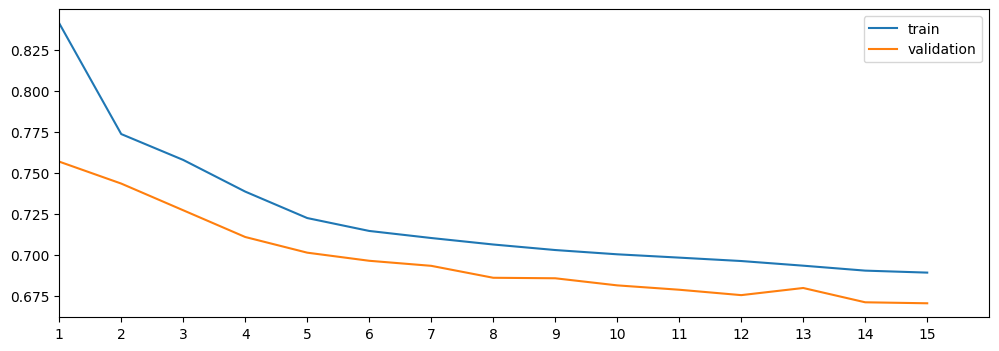

Epoch:15 Training Loss:0.6892443088156489 Validation Loss:0.6705430346131325: 100%|██████████| 15/15 [06:09<00:00, 24.65s/it]


Trainingloss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
Validationloss,█▇▆▄▄▃▃▂▂▂▂▁▂▁▁
acc,▁▇▄▇▆▇▆▆▄▆▆▆▅▆▄▆▁▆▅▆▃▆█▆▅▆▅▆▅▆
Trainingloss,0.68924
Validationloss,0.67054
acc,0.73439


In [39]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()
traintestpipeline(15,optimizer, loss, 10000, "AE3.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.5877128].


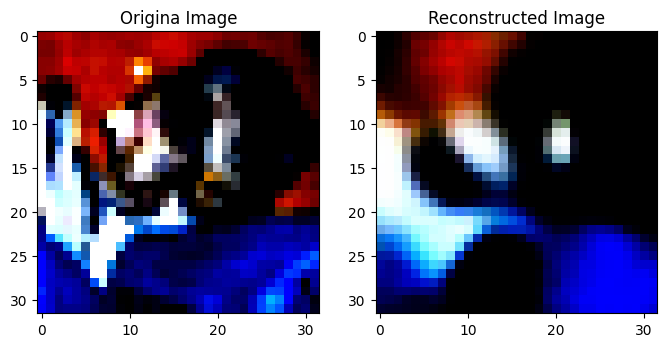

MSE: tensor(0.6705, device='cuda:1')
MAE: tensor(0.6449, device='cuda:1')


In [40]:
assignPretrainedModel(device, "AE3.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

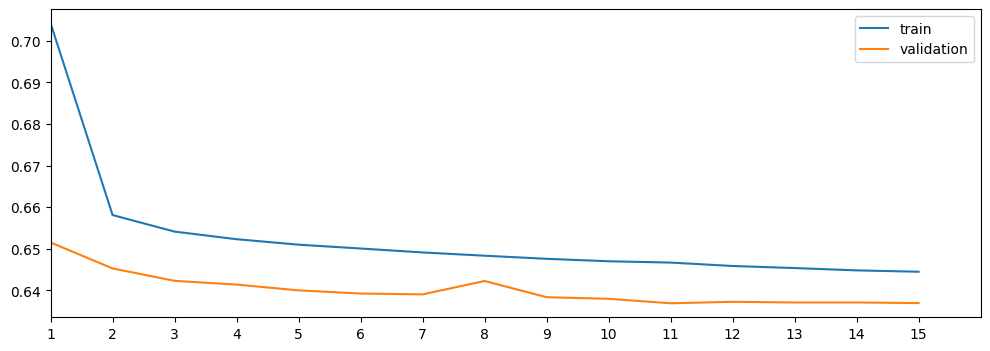

Epoch:15 Training Loss:0.64449667226217 Validation Loss:0.6369682068228721: 100%|██████████| 15/15 [06:09<00:00, 24.61s/it]  


Trainingloss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Validationloss,█▅▄▃▂▂▂▄▂▂▁▁▁▁▁
acc,▃▄▃▄▁▄▃▄▄▄▄▄▅▄▅▄▅▄▃▄█▄▅▄▁▄▂▄▂▄
Trainingloss,0.6445
Validationloss,0.63697
acc,0.72963


In [41]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
loss = nn.L1Loss()
traintestpipeline(15,optimizer, loss, 10000, "AE4.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.5877128].


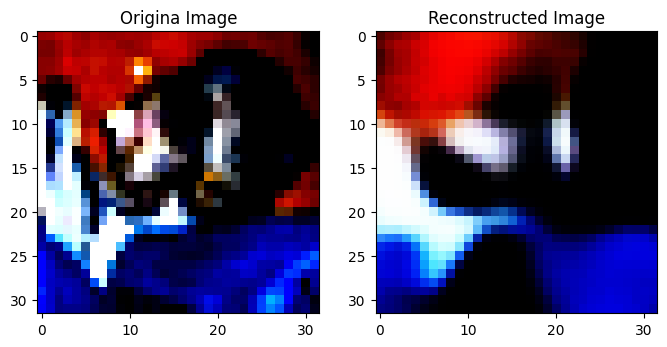

MSE: tensor(0.6650, device='cuda:1')
MAE: tensor(0.6369, device='cuda:1')


In [42]:
assignPretrainedModel(device, "AE4.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

### smaller decoder and bottleneck

In [283]:
encoder = vgg19_bn(weights=None, progress=True)
encoder = encoder.features[:26]
print(encoder)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [52]:
class AutoEncoderSmaller(torch.nn.Module):
	def __init__(self, encoder):
		super().__init__()

		self.bottleneck_dim = 512 
		self.latent_dim = 256*16*16
	
		self.encoder = encoder
		self.bottleneck = nn.Sequential(
            nn.Flatten(),  # Aplana a 1D
            nn.Linear(self.latent_dim, self.bottleneck_dim),  # Reducción
            nn.ReLU(inplace=True),
            nn.Linear(self.bottleneck_dim, self.latent_dim),  # Expansión
            nn.ReLU(inplace=True)
        )

		self.decoder = nn.Sequential(
	    nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
      	nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True),

	    nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
      	nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True),

	    nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.ReLU(inplace=True),
		  
      	nn.ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
      	nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		encoded_flat = encoded.view(encoded.shape[0], -1)
		bottle = self.bottleneck(encoded_flat)
		reshaped = bottle.view(-1, 256, 16, 16)  
		decoded = self.decoder(reshaped)
		return decoded

In [53]:
model = AutoEncoderSmaller(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
loss = nn.MSELoss()
traintestpipeline(15,optimizer, loss, 10000, "autoencoderSmall.pt")

  0%|          | 0/15 [00:04<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (15x8192 and 65536x512)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7511113].


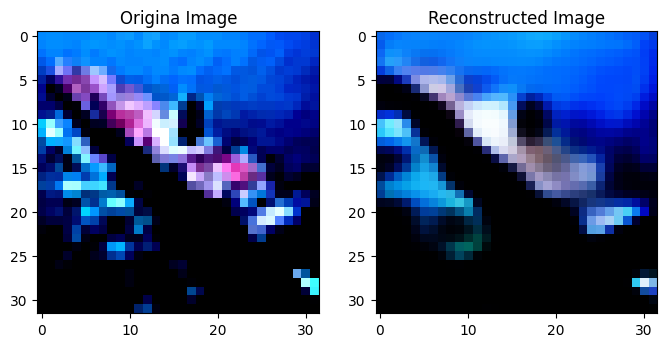

MSE: tensor(0.6317, device='cuda:1')
MAE: tensor(0.6074, device='cuda:1')


In [264]:
assignPretrainedModel(device, "autoencoderSmall.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

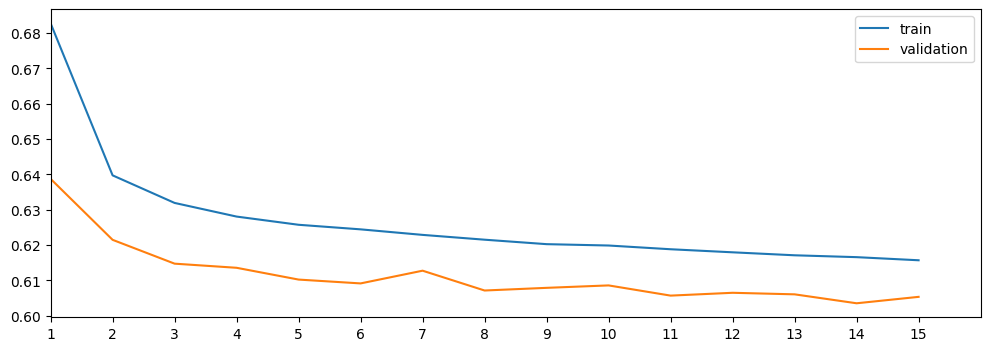

Epoch:15 Training Loss:0.6157110076526116 Validation Loss:0.6053638710826635: 100%|██████████| 15/15 [03:45<00:00, 15.04s/it]


Trainingloss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
Validationloss,█▅▃▃▂▂▃▂▂▂▁▂▂▁▁
acc,▃▆▄▄█▅▅▆█▃▄▂▄▄▄▄▅▅▆█▆▁▅▄▃▆▃▄▅▅
Trainingloss,0.61571
Validationloss,0.60536
acc,0.71235


In [265]:
model = AutoEncoderSmaller(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
loss = nn.L1Loss()
traintestpipeline(15,optimizer, loss, 10000, "autoencoderSmallMAE.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


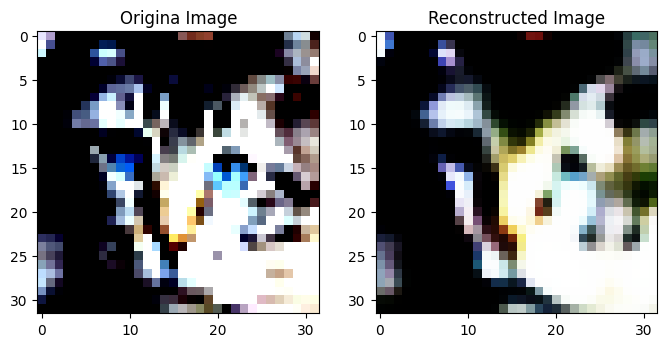

MSE: tensor(0.6299, device='cuda:1')
MAE: tensor(0.6035, device='cuda:1')


In [266]:
assignPretrainedModel(device, "autoencoderSmallMAE.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

# Resize Image

In [267]:
training_set = CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
test_set = CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))

In [271]:
train_dl = DataLoader(Subset(training_set, range(10000)), batch_size=TRAINING_SIZE,shuffle=True, num_workers=2)
test_dl = DataLoader(Subset(test_set, range(4000)), batch_size=TEST_SIZE,shuffle=True, num_workers=2)

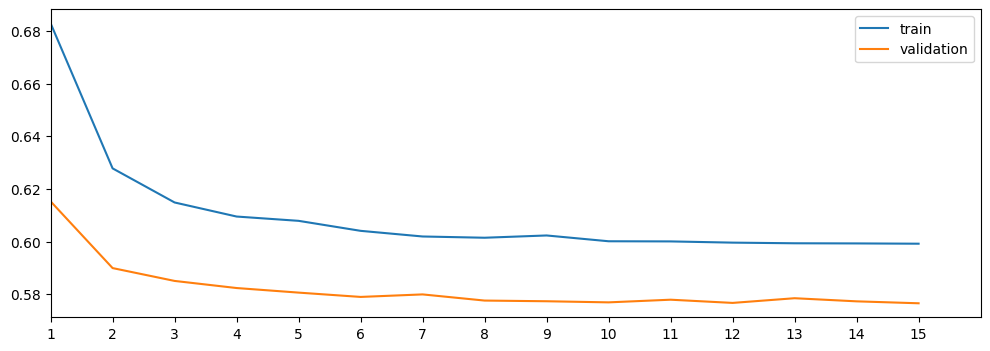

Epoch:15 Training Loss:0.5992009886826711 Validation Loss:0.5765810126811266: 100%|██████████| 15/15 [18:23<00:00, 73.54s/it]


Trainingloss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
Validationloss,█▃▃▂▂▁▂▁▁▁▁▁▁▁▁
acc,▃▆▃▅▂▆▇▆▃▅█▆█▂▄▃▅▂▁▂▅▁▅▅▃▆▃▃▃▃
Trainingloss,0.5992
Validationloss,0.57658
acc,0.53269


In [272]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
loss = nn.MSELoss()
traintestpipeline(15,optimizer, loss, 10000, "autoencoderBiggerImage.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.64].


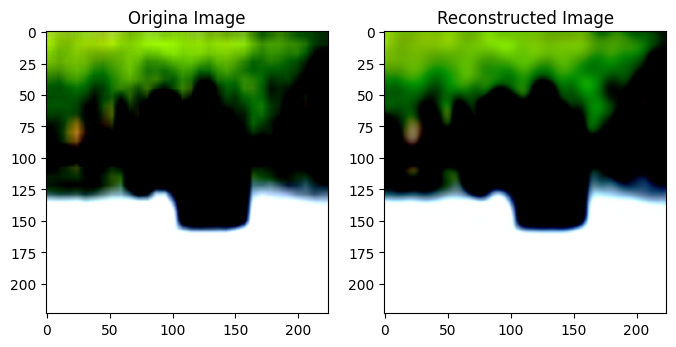

MSE: tensor(0.5766, device='cuda:1')
MAE: tensor(0.5496, device='cuda:1')


In [273]:
assignPretrainedModel(device, "autoencoderBiggerImage.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

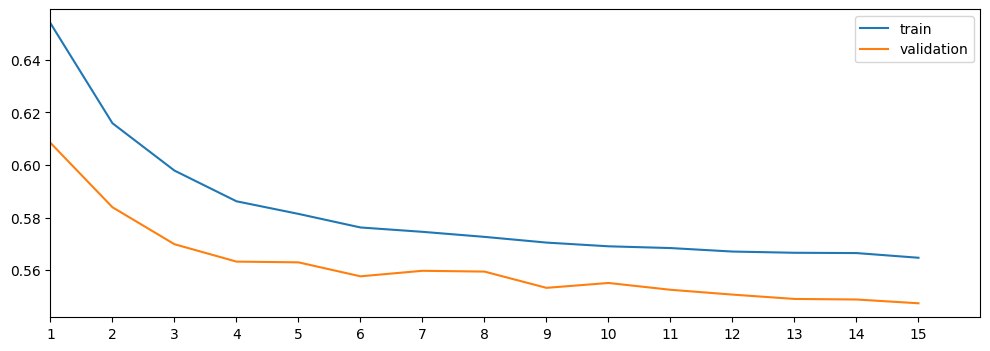

Epoch:15 Training Loss:0.5646867001878804 Validation Loss:0.5473698247969151: 100%|██████████| 15/15 [18:23<00:00, 73.54s/it]


Trainingloss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
Validationloss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
acc,▅▂▄▂▅▄▃▄▂▃▅▄▅▆▄▃▃▄█▅▅▆▄▄▃▅▁▃▅▄
Trainingloss,0.56469
Validationloss,0.54737
acc,0.59221


In [281]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
loss = nn.L1Loss()
traintestpipeline(15,optimizer, loss, 10000, "autoencoderBiggerImageMAE.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.3611329].


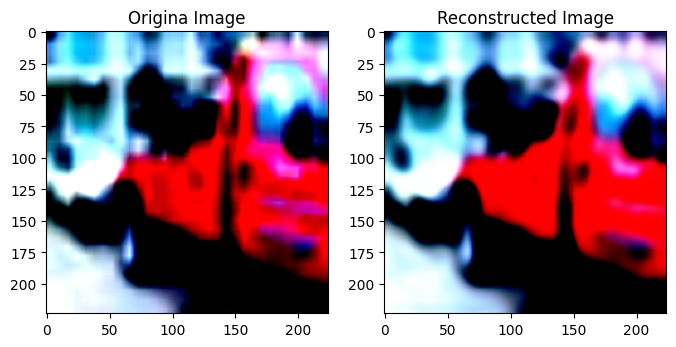

MSE: tensor(0.5762, device='cuda:1')
MAE: tensor(0.5474, device='cuda:1')


In [282]:
assignPretrainedModel(device, "autoencoderBiggerImageMAE.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

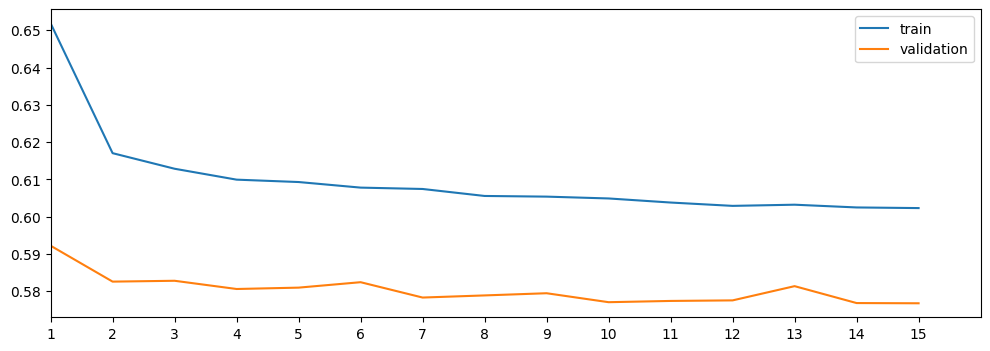

Epoch:15 Training Loss:0.6022968428960626 Validation Loss:0.5767607183754444: 100%|██████████| 15/15 [14:20<00:00, 57.40s/it]


Trainingloss,▆▂▁▁█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
Validationloss,▅▃▃▂█▄▄▃▃▄▂▂▂▁▁▁▃▁▁
acc,▃▃▄▁▄█▆▄▄▃▅▄▄▃▄▅▃▆▆▃▄▆▃▃▃▃█▆▃▁▂▅▃▄▁▆▅▄
Trainingloss,0.6023
Validationloss,0.57676
acc,0.57115


In [286]:
model = AutoEncoderSmaller(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
loss = nn.MSELoss()
traintestpipeline(15,optimizer, loss, 10000, "autoencoderSmallBiggerImage.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].


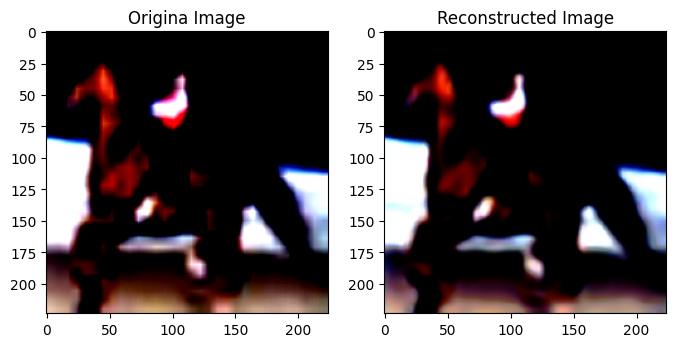

MSE: tensor(0.5768, device='cuda:1')
MAE: tensor(0.5509, device='cuda:1')


In [287]:
assignPretrainedModel(device, "autoencoderSmallBiggerImage.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

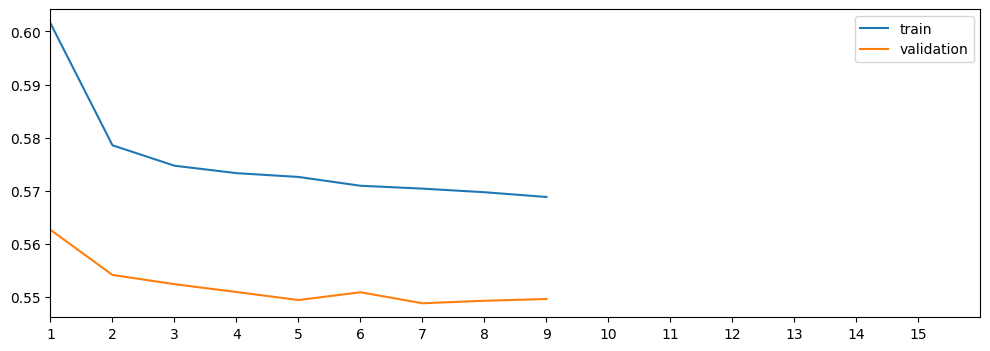

 90%|████████▉ | 598/667 [00:42<00:04, 13.92it/s]on Loss:0.5495935286581516:  60%|██████    | 9/15 [08:36<05:44, 57.42s/it]
Epoch:9 Training Loss:0.5688162278020936 Validation Loss:0.5495935286581516:  60%|██████    | 9/15 [09:19<06:13, 62.21s/it]


KeyboardInterrupt: 

In [288]:
model = AutoEncoderSmaller(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
loss = nn.L1Loss()
traintestpipeline(15,optimizer, loss, 10000, "autoencoderSmallBiggerImageMAE.pt")

In [ ]:
assignPretrainedModel(device, "autoencoderSmallBiggerImageMAE.pt")
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

# Leaky RELU and simpler decoder

In [397]:
encoder = vgg19_bn(weights=None, progress=True)
encoder = encoder.features[:10]
print(encoder)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
)


- without upsample and LeakyRelu

In [407]:
class AutoEncoder(torch.nn.Module):
	def __init__(self, encoder):
		super().__init__()
	
		self.encoder = encoder
		
		self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Scale to (0,1)
        )

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


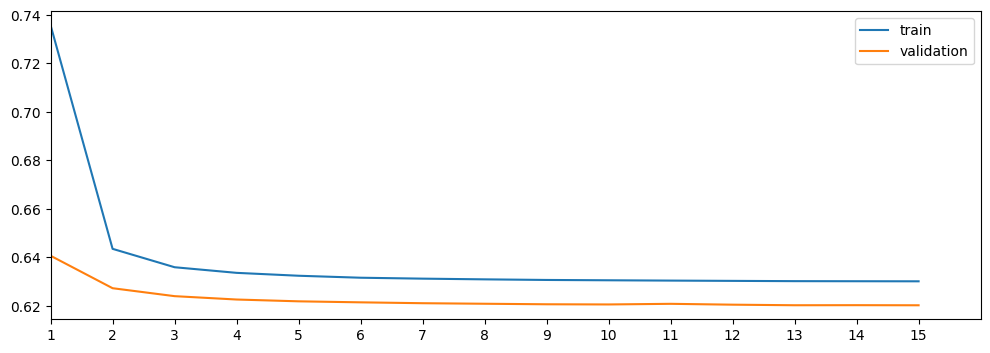

Epoch:15 Training Loss:0.6300200816840559 Validation Loss:0.6201206909120083: 100%|██████████| 15/15 [04:51<00:00, 19.42s/it]


Trainingloss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validationloss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
acc,▄▅▃▄▃▄█▄▇▄▂▄▃▄▃▄▁▄▃▄▄▄▃▄▂▄▄▄▆▄
Trainingloss,0.63002
Validationloss,0.62012
acc,0.80541


In [412]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-5)
loss = nn.MSELoss()
traintestpipeline(15,optimizer, loss, 10000, "autoencoderLeaky.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.5877128].


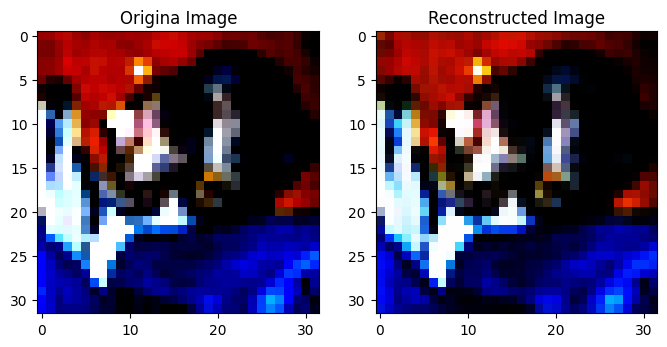

MSE: tensor(0.6201, device='cuda:1')
MAE: tensor(0.5745, device='cuda:1')


In [413]:
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)

In [419]:
training_set = CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
test_set = CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))

In [422]:
train_dl = DataLoader(training_set, batch_size=64,shuffle=True, num_workers=2)
test_dl = DataLoader(test_set, batch_size=64,shuffle=True, num_workers=2)

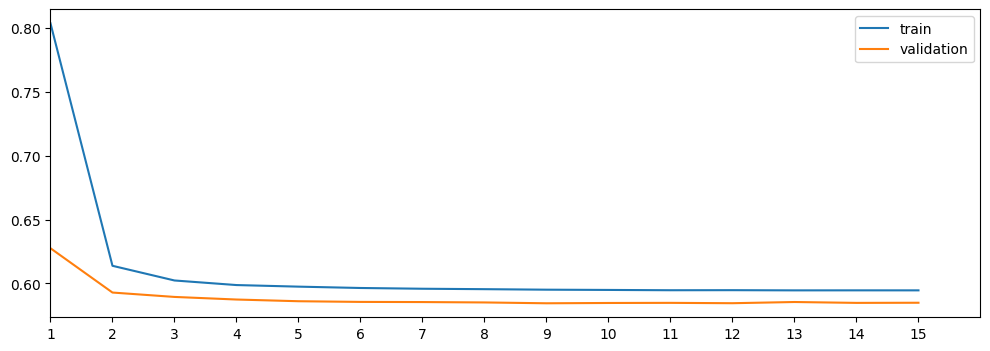

Epoch:15 Training Loss:0.5946278871630158 Validation Loss:0.584942324525991: 100%|██████████| 15/15 [31:31<00:00, 126.08s/it]


Trainingloss,▆▃▂▃▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validationloss,█▆▆▁▁▁▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁
acc,██▄█▃█▃▃▂▃▃▆▄█▃▃▅▄▁▄▂▃▃▄▃▅▃▄▁▄▃▂▃▅▂▃▆▅▄▄
Trainingloss,0.59463
Validationloss,0.58494
acc,0.60264


In [423]:
model = AutoEncoder(encoder)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-5)
loss = nn.MSELoss()
traintestpipeline(15,optimizer, loss, 10000, "autoencoderLeakyResize.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.465708].


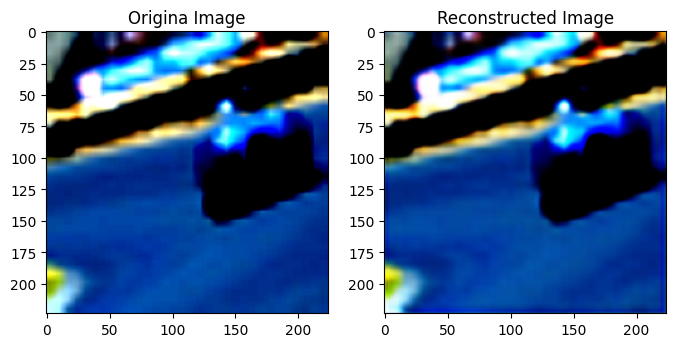

MSE: tensor(0.5853, device='cuda:1')
MAE: tensor(0.5463, device='cuda:1')


In [424]:
showImages(test_dl, model)
calculate_metrics(model, test_dl, device)